In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestRegressor

# Đọc dữ liệu 14 năm từ file Excel
df = pd.read_excel("data_nckh.xlsx", parse_dates=["Time"])
df = df.sort_values("Time")  # sắp xếp theo thời gian

# Kiểm tra và xử lý dữ liệu missing/duplicate
assert df["Time"].is_unique, "Thời gian bị trùng lặp!"  # đảm bảo không trùng
assert df.isnull().sum().sum() == 0, "Có giá trị null trong dữ liệu!"  # đảm bảo không có null

# Lấy cột giá vàng Việt Nam làm biến mục tiêu, các cột khác làm đặc trưng
target_col = "Gold_Price_VN"
feature_cols = ["CPI_VN", "Gold_Price_World", "Oil_Price", "Tỷ giá USD/VND", "VN-Index", 
                "CPI_USA", "SM_M2", "SX_CN", "INTEREST_RATE", "GSI", "GSI_VN"]

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df[target_col] = scaler.fit_transform(df[[target_col]])

# Chuẩn bị dữ liệu cho mô hình
features = df[feature_cols].values
target = df[target_col].values

print("Tổng số mẫu:", len(df))

# Tạo dữ liệu train và test
X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.2)
print("Số mẫu train:", len(X_train), " | Số mẫu test:", len(X_test))

# Tạo dữ liệu chuỗi cho LSTM
time_step = 30  # độ dài chuỗi đầu vào cho LSTM

def create_sequences(X, y, time_step=30):
    X_seq, y_seq = [], []
    for i in range(time_step, len(X)):
        X_seq.append(X[i-time_step:i])    # đoạn [i-time_step ... i-1]
        y_seq.append(y[i])                # giá trị tại thời điểm i (dự báo ở bước kế)
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_step)
X_test_seq, y_test_seq = create_sequences(np.vstack([X_train[-time_step:], X_test]), 
                                         np.concatenate([y_train[-time_step:], y_test]), 
                                         time_step)

# Xây dựng mô hình LSTM với nhiều layer hơn và BatchNormalization
lstm_model = models.Sequential([
    layers.LSTM(128, activation='tanh', return_sequences=True, input_shape=(time_step, X_train_seq.shape[2])),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.LSTM(64, activation='tanh', return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.LSTM(32, activation='tanh', return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Huấn luyện LSTM
lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Dự báo bằng LSTM trên tập test
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()

print("LSTM – R^2: %.9f, RMSE: %.5f, MAE: %.5f" % (
    r2_score(y_test_seq, y_pred_lstm), 
    np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm)), 
    mean_absolute_error(y_test_seq, y_pred_lstm)
))

import matplotlib.pyplot as plt

# Lấy ngày tương ứng với tập test (giả sử 'df' có cột 'Time')
test_dates = df["Time"].iloc[-len(y_test_seq):]

# Vẽ biểu đồ so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(12, 6))
plt.plot(test_dates, scaler.inverse_transform(y_test_seq.reshape(-1, 1)), label="Actual Price", color='blue', linewidth=2)
plt.plot(test_dates, scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)), label="Predicted Price", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Gold Price (Triệu/lượng)")
plt.title("Actual vs Predicted Gold Price - LSTM Model")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Tổng số mẫu: 5479
Số mẫu train: 4383  | Số mẫu test: 1096


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 0.0920 - val_loss: 0.0985
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0279 - val_loss: 0.0466
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0163 - val_loss: 0.0369
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0104 - val_loss: 0.0344
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0069 - val_loss: 0.0019
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0059 - val_loss: 0.0028
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 12/100
123/123 ━━━━━━━━

KeyboardInterrupt: 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [4]:
df = pd.read_excel('data_nckh.xlsx')
print(df)

            Time  Gold_Price_VN  CPI_VN  Gold_Price_World  Oil_Price  \
0     01/01/2010         26.700    1.36           1087.50      83.25   
1     02/01/2010         26.700    1.36           1087.50      83.25   
2     03/01/2010         26.701    1.36           1087.50      83.25   
3     04/01/2010         26.760    1.36           1121.50      83.25   
4     05/01/2010         26.960    1.36           1123.25      83.25   
...          ...            ...     ...               ...        ...   
5474  27/12/2024         84.700    0.29           2615.95      70.08   
5475  28/12/2024         84.700    0.29           2615.95      70.08   
5476  29/12/2024         84.700    0.29           2615.95      70.28   
5477  30/12/2024         84.500    0.29           2609.10      70.99   
5478  31/12/2024         84.200    0.29           2609.10      71.56   

      Tỷ giá USD/VND  SX_CN  VN-Index  CPI_USA     SM_M2  INTEREST_RATE  \
0            18469.0    0.0    517.05      1.6   1951164    

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - loss: 0.1587 - val_loss: 0.1289
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0393 - val_loss: 0.0821
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0223 - val_loss: 0.0368
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0128 - val_loss: 0.0088
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0096 - val_loss: 0.0046
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0082 - val_loss: 0.0235
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0080 - val_loss: 0.0031
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 12/100
123/123 ━━━━━━━━

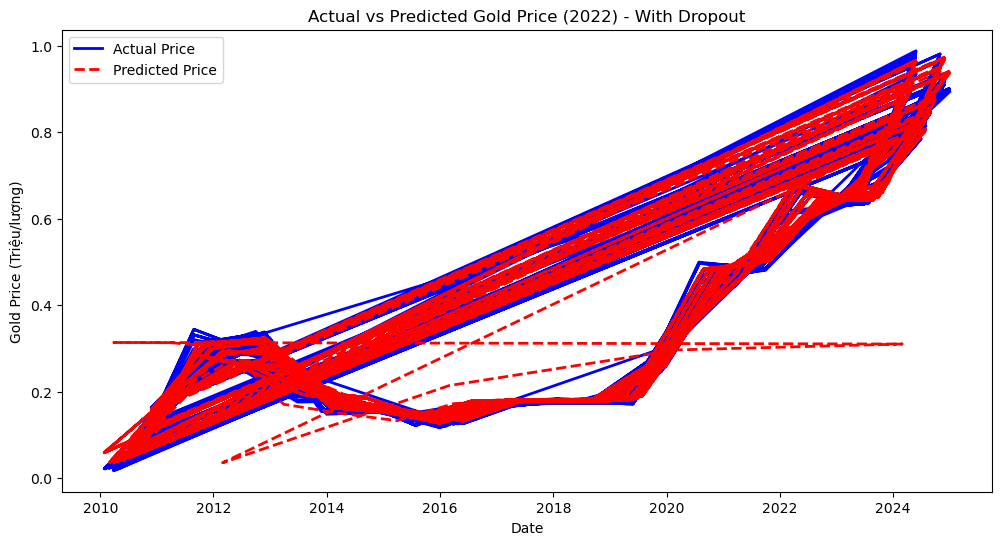

In [17]:
from tensorflow.keras import layers, models
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Chuyển đổi cột thời gian thành định dạng datetime nếu chưa được đặt làm index
if not isinstance(df.index, pd.DatetimeIndex):
    df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y')
    df.set_index('Time', inplace=True)

# Chọn dữ liệu giá vàng cần dự đoán
target = df[['Gold_Price_VN']].values
feature = df[['Gold_Price_World', 'Oil_Price', 'Tỷ giá USD/VND', 'VN-Index', 'CPI_USA', 'SM_M2', 'SX_CN', 'INTEREST_RATE', 'GSI', 'GSI_VN']].values

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target)
features_scaled = scaler.fit_transform(feature)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, shuffle=False, test_size=0.2)

# Tạo dữ liệu theo dạng chuỗi thời gian cho mô hình LSTM
def create_sequences(X, y, time_step=30):
    X_seq, y_seq = [], []
    for i in range(time_step, len(X)):
        X_seq.append(X[i-time_step:i])    # đoạn [i-time_step ... i-1]
        y_seq.append(y[i])                # giá trị tại thời điểm i (dự báo ở bước kế)
    return np.array(X_seq), np.array(y_seq)

time_step = 30
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_step)
X_test_seq, y_test_seq = create_sequences(np.vstack([X_train[-time_step:], X_test]), 
                                         np.concatenate([y_train[-time_step:], y_test]), 
                                         time_step)

# Xây dựng mô hình LSTM với Dropout
model = models.Sequential([
    layers.LSTM(128, activation='tanh', return_sequences=True, input_shape=(time_step, X_train_seq.shape[2])),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.LSTM(64, activation='tanh', return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.LSTM(32, activation='tanh', return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile mô hình
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Dự đoán giá vàng
predicted_price = model.predict(X_test_seq).flatten()

# Đánh giá mô hình
print("LSTM – R^2: %.9f, RMSE: %.5f, MAE: %.5f" % (
    r2_score(y_test_seq, predicted_price), 
    np.sqrt(mean_squared_error(y_test_seq, predicted_price)), 
    mean_absolute_error(y_test_seq, predicted_price)
))

# Lấy ngày tương ứng với tập test
test_dates = df.index[-len(y_test_seq):]

# Vẽ biểu đồ so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_seq, label="Actual Price", color='blue', linewidth=2)
plt.plot(test_dates, predicted_price, label="Predicted Price", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Gold Price (Triệu/lượng)")
plt.title("Actual vs Predicted Gold Price (2022) - With Dropout")
plt.legend()
plt.show()
